# Signal Conversion Lab1 - Sar ADC

## General Functions

In [36]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt  
from numba.typed import List
from numba import njit, prange

#import datetime

TYPE = float#np.float64

def num2bin(n,n_bits):
    
    tmp = [ int(i) for i in bin(n)[2:] ]
    if len(tmp) < n_bits:
        code = np.append( [ int(0) for _ in range( int(n_bits) - len(tmp)  ) ],tmp  )
    else:
        code = np.asarray(tmp,dtype=int)
    
    return np.flip(code)


## DAC

$$V_x^{\phi_{n+1}} = V_x^{\phi_n}+V_{r}\frac{ C_{B} {\Delta}C_{Li} + C_{B} {\Delta}C_{Mi} + S_{LC} {\Delta}C_{Mi}}{C_{B}\left( S_{LC} + S_{MC}\right) + S_{LC} S_{MC}}$$


$~$
Where:

$\displaystyle S_{LC} = C_{0'} + \sum_{i=0}^{\text{bits LSB}}C_i$

$\displaystyle S_{MC} = C_{M0} + \sum_{i=0}^{\text{bits MSB}}(C_{ai}+C_{bi})$

#TODO
$\Delta C_{Li} = $ 

$\Delta C_{Mi} = $ 

In [37]:
@njit(fastmath=True)
def dac_bit_weight(Vr,C_ai, C_bi,C_M0, C_Li,C_B,C_B0l,n_bits=-1):

    C_abi = C_ai + C_bi
    S_LC  = sum(C_Li) + C_B0l 
    S_MC  = sum(C_abi) + C_M0

    # First calculate constant values
    slope = Vr/( C_B*( S_MC + S_LC ) + S_LC*S_MC )

    S_LC_PLUS_C_B = S_LC + C_B
    
    tf = [[0.0 for _ in range(2)] for _ in range(n_bits)] #np.empty(shape=(n_bits,2),dtype=TYPE))
    
    i  = 0
    for c in C_Li:
        tf[i][0] = 0
        tf[i][1] = slope*C_B*c
        i += 1
    
    tf[i][0] =  0
    tf[i][1] = slope*S_LC_PLUS_C_B*C_M0 
    
    for j in range(len( C_ai )):
        #tf[pos] = (b = 0, b = 1)
        i += 1
        tf[i][0] = -slope*S_LC_PLUS_C_B*C_bi[j]
        tf[i][1] = slope*S_LC_PLUS_C_B*C_ai[j]
    return tf
    



def get_Vlsb_real( dac_tf ):
    
    dac_len = len(dac_tf) - 1
    return ( dac_tf[ dac_len  ] - dac_tf[0] ) / dac_len 

def get_INL(dac_tf, Vlsb_real):

    dac_len = len(dac_tf)
    return (dac_tf - np.arange(dac_len) * Vlsb_real - dac_tf[0]) / Vlsb_real

def get_DNL(dac_tf, Vlsb_real):

    return ((dac_tf[1:] - dac_tf[:-1]) / Vlsb_real) - 1
   

### Dac Test

[[0.0, 0.00048828125], [0.0, 0.0009765625], [0.0, 0.001953125], [0.0, 0.00390625], [0.0, 0.0078125], [0.0, 0.015625], [-0.015625, 0.015625], [-0.03125, 0.03125], [-0.0625, 0.0625], [-0.125, 0.125], [-0.25, 0.25]]
0.0009765625


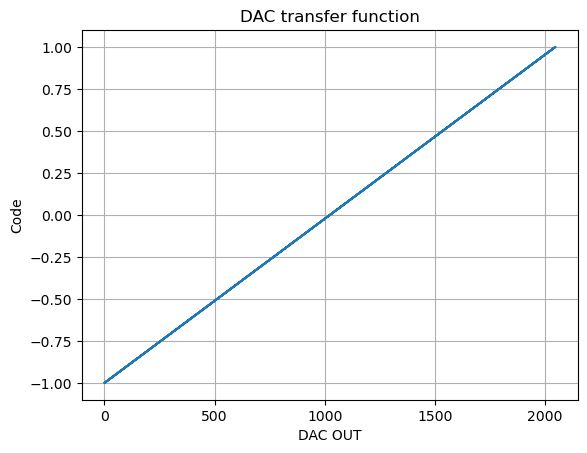

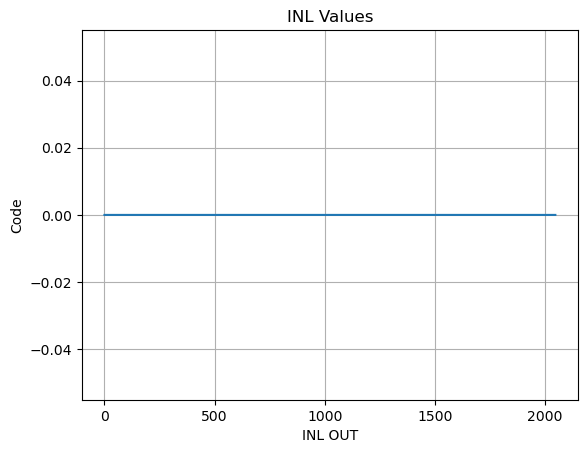

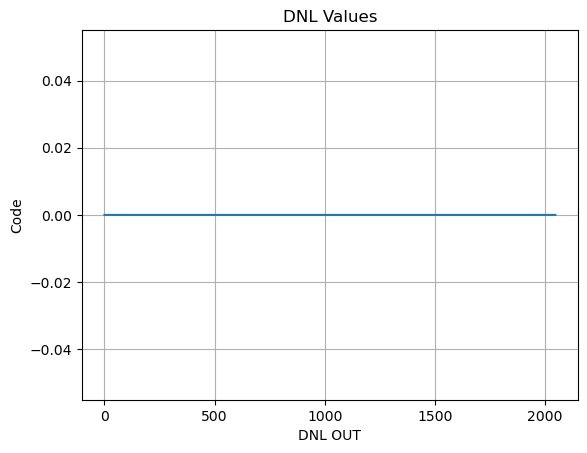

In [38]:
#Ideal values
n_bits = 11
C_ai   = np.asarray([ 1, 2, 4, 8, 16])
C_bi   = np.asarray([ 1, 2, 4, 8, 16])
C_Li   = np.asarray([ 1, 2, 4, 8, 16 ])
C_M0   = 1
C_B    = (2**(len(C_Li)))/( (2**(len(C_Li))) - 1 )
C_B0l  = 1
vr     = 1

weights = dac_bit_weight(
            vr,
            C_ai,
            C_bi,
            C_M0, 
            C_Li,
            C_B,
            C_B0l,
            n_bits=n_bits
) 
print(weights)
res_dac = np.zeros(shape=(2**n_bits),dtype=TYPE)
for j in range(0,2**n_bits ):
    code = num2bin(j,n_bits)
    i = 0
    for b in code:
        res_dac[j] += weights[i][b] - weights[i][(b-1)*(-1)]
        i += 1

Vlsb_real = get_Vlsb_real(res_dac)
print(Vlsb_real)
inl_res = get_INL(res_dac, Vlsb_real)

dnl_res = get_DNL(res_dac, Vlsb_real)

#Plots
x = [ n for n in range(0,2**n_bits) ]
plt.step(x, res_dac,where='mid')
#plt.plot(x, res_dac, 'o', color='orange')
plt.xlabel("DAC OUT")
plt.ylabel("Code")
plt.title("DAC transfer function")
#  plt.legend()
plt.grid(True)
plt.show()

plt.step(x, inl_res,where='mid')
#plt.plot(x, res_dac, 'o', color='orange')
plt.xlabel("INL OUT")
plt.ylabel("Code")
plt.title("INL Values")
plt.grid(True)
plt.show()

plt.step(x[:-1], dnl_res,where='mid')
#plt.plot(x, res_dac, 'o', color='orange')
plt.xlabel("DNL OUT")
plt.ylabel("Code")
plt.title("DNL Values")
plt.grid(True)
plt.show()

## ADC

In [39]:
code_vec  = np.asarray([ 2**i for i in range( 0,n_bits+1 ) ])
bit_masks = np.array([1 << i for i in range(n_bits+1)], dtype=int)

def code2num(code) -> int:
    return np.sum(code*code_vec)

@njit(nopython=True,fastmath=True)
def adc(vin,dac_weights,n_bits_dac,Voffset=0) -> list[int]:

    ind   = n_bits_dac  
    b_aux = vin > 0
    res = bit_masks[n_bits_dac]*b_aux

    for i in range(n_bits_dac-1,-1,-1):
        
        vin  += dac_weights[i][int(not(b_aux))] - dac_weights[i][int(b_aux)]
        b_aux =  vin > Voffset
        ind  -= 1
        res  += bit_masks[i]*b_aux
        
    return res

@njit(nopython=True, fastmath=True, parallel=True)
def adc_tf(num_points,n_bits_dac,Vr,dac_weights,Voffset=0):

   # allocate
    tf_all = np.empty(num_points, dtype=int)
    vin    = np.empty(num_points, dtype=float)
    delta  = Vr / (num_points - 1)

    for i in prange(num_points):
        v = -Vr/2 + i * delta
        vin[i]    = v
        tf_all[i] = adc(v, dac_weights, n_bits_dac, Voffset)
    return tf_all, vin

    delta = (Vr) / (num_points - 1)
    vin   =  [-Vr/2 + i * delta for i in range(num_points)]
    return [ adc(v, dac_weights, n_bits_dac,Voffset) for v in vin ] , vin

@njit(nopython=True, parallel=True)
def get_trans(vin,tf_all,n_bits):

    #tf_tran = np.empty((2 << (n_bits-1), 2), dtype=TYPE)
    code_tran = np.empty((2 << (n_bits-1)), dtype=int) 
    vin_tran = np.empty((2 << (n_bits-1)), dtype=TYPE) 
    
    j = 0
    prev = tf_all[0]
    for i in prange(1, len(tf_all)):
        curr = tf_all[i]
        if curr != prev:
            vin_tran[j]  = vin[i]
            code_tran[j] = curr
            j += 1
        prev = curr
    # Slice to actual number of transitions
    return vin_tran[:j],code_tran[:j]
'''
@njit(nopython=True)
def get_trans(vin,tf_all,n_bits):

    tf_tran = np.empty((2 << (n_bits-1), 2), dtype=TYPE)
    
    j = 0
    prev = tf_all[0]
    for i in range(1, len(tf_all)):
        curr = tf_all[i]
        if curr != prev:
            tf_tran[j, 0] = vin[i]
            tf_tran[j, 1] = curr
            j += 1
        prev = curr
    # Slice to actual number of transitions
    return tf_tran
'''

/usr/lib/python3.13/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


'\n@njit(nopython=True)\ndef get_trans(vin,tf_all,n_bits):\n\n    tf_tran = np.empty((2 << (n_bits-1), 2), dtype=TYPE)\n\n    j = 0\n    prev = tf_all[0]\n    for i in range(1, len(tf_all)):\n        curr = tf_all[i]\n        if curr != prev:\n            tf_tran[j, 0] = vin[i]\n            tf_tran[j, 1] = curr\n            j += 1\n        prev = curr\n    # Slice to actual number of transitions\n    return tf_tran\n'

### ADC Test

In [40]:
tf_all,vin = adc_tf(100*2**n_bits,n_bits,vr*2,weights)
vin_trans,code_trans = get_trans(vin,tf_all,n_bits+1)

step = 2 / (100 * 2**(n_bits))
x = np.arange(-1, 1, step)

plt.step(x,tf_all,where='mid')
plt.step(vin_trans, code_trans, '.', color='orange')
plt.ylabel("ADC OUT")
plt.xlabel("Vi")
plt.title("ADC transfer function")
#  plt.legend()
plt.grid(True)
plt.show()
'''
tf_all,vin = adc_tf(100*2**n_bits,n_bits,vr*2,weights)
tf_trans   = get_trans(vin,tf_all,n_bits+1)

step = 2 / (100 * 2**(n_bits))
x = np.arange(-1, 1, step)

plt.step(x,tf_all,where='mid')
plt.step(tf_trans[:,0], tf_trans[:,1], '.', color='orange')
plt.ylabel("ADC OUT")
plt.xlabel("Vi")
plt.title("ADC transfer function")
#  plt.legend()
plt.grid(True)
plt.show()
'''

TypeError: cannot reflect element of reflected container: reflected list(reflected list(float64)<iv=None>)<iv=None>


# Monte Carlo

In [ ]:
#Ideal values
n_bits  = 11
C_ai    = np.asarray([ 1, 2, 4, 8, 16])
C_bi    = np.asarray([ 1, 2, 4, 8, 16])
C_Li    = np.asarray([ 1, 2, 4, 8, 16 ])
C_M0    = 1
C_B     = (2**(len(C_Li)))/( (2**(len(C_Li))) - 1 )
C_B0l   = 1
vr      = 1
Voffset = 0 
'''
def gen_components(s_cap,n_sim):
    # For vector caps: shape = (M, N)
    mc_C_ai = np.random.normal(loc=C_ai,  scale=s_cap, size=(n_sim, C_ai.size))
    mc_C_bi = np.random.normal(loc=C_bi,  scale=s_cap, size=(n_sim, C_bi.size))
    mc_C_Li = np.random.normal(loc=C_Li,  scale=s_cap, size=(n_sim, C_Li.size))

    # For scalars, just draw M samples
    mc_C_M0  = np.random.normal(loc=C_M0,  scale=s_cap, size=n_sim)
    mc_C_B0l = np.random.normal(loc=C_B0l, scale=s_cap, size=n_sim)
    
    #TODO Vr e Voffset e CB

    return mc_C_ai, mc_C_bi, mc_C_Li, mc_C_M0, mc_C_B0l
'''


@njit(parallel=True)
def monte_carlo_aux(n_sim,mc_C_ai,mc_C_bi,mc_C_Li,mc_C_M0,mc_C_B0l,vin_res, code_res):
    
    mc_C_B      = C_B
    Vr          = 1
    Voffset     = 0
    n_bits_dac  = C_ai.size + C_Li.size + 1
    n_bits_adc  = n_bits_dac + 1

    num_points  = 100*2**n_bits

    #res = np.empty(shape=n_sim,dtype=object)

    #print(res)
    #res = List(res)
    
    for i in prange(n_sim):

        weights =  dac_bit_weight(#TODO nao esquecer de indexar cb e vr
            Vr,
            mc_C_ai[i], mc_C_bi[i],
            mc_C_M0[i],mc_C_Li[i],
            mc_C_B, mc_C_B0l[i],
            n_bits
            )
        tf_all, vin = adc_tf(num_points,n_bits_dac,Vr,weights,Voffset)
        t,c = get_trans(vin,tf_all,n_bits_adc)
        
        #vin_res[i]  = t
        #code_res[i] = c
        vin_res.append(t)
        code_res.append(c)
    return vin_res,code_res

def monte_carlo(s_cap, n_sim):
    mc_C_ai  = np.random.normal(loc=C_ai,  scale=s_cap, size=(n_sim, C_ai.size))
    mc_C_bi  = np.random.normal(loc=C_bi,  scale=s_cap, size=(n_sim, C_bi.size))
    mc_C_Li  = np.random.normal(loc=C_Li,  scale=s_cap, size=(n_sim, C_Li.size))
    mc_C_M0  = np.random.normal(loc=C_M0,  scale=s_cap, size=n_sim)
    mc_C_B0l = np.random.normal(loc=C_B0l, scale=s_cap, size=n_sim)

    #vin_res  = np.empty(n_sim, dtype=object)
    #code_res = np.empty(n_sim, dtype=object)
    vin_res  = List() 
    code_res = List()
    return monte_carlo_aux(
        n_sim,mc_C_ai,
        mc_C_bi, mc_C_Li,
        mc_C_M0, mc_C_B0l,
        vin_res, code_res
    )

nsim = 1000
vin_res,code_res  = monte_carlo(0.05,nsim)

for i in range(nsim):

    plt.step(vin_res[i],code_res[i],where='pre')
    plt.ylabel("ADC OUT")
    plt.xlabel("Vi")
    plt.title("ADC transfer function")
    #  plt.legend()
plt.grid(True)
plt.show()
